<a href="https://colab.research.google.com/github/yyousharashid-lab/CVPR/blob/main/MID/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import os
image_dir = '/content/drive/MyDrive/animal_dataset'
Categories = [c for c in os.listdir(image_dir)]
print(Categories)

['panda', 'dog', 'cat']


In [ ]:
train_data = []
IMG_SIZE = 64

for c in Categories:
    path = os.path.join(image_dir, c)
    class_num = Categories.index(c)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img))
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            train_data.append([img_arr, class_num])
        except Exception as e:
            pass

print(f"\nTotal images: {len(train_data)}")


Total images: 300


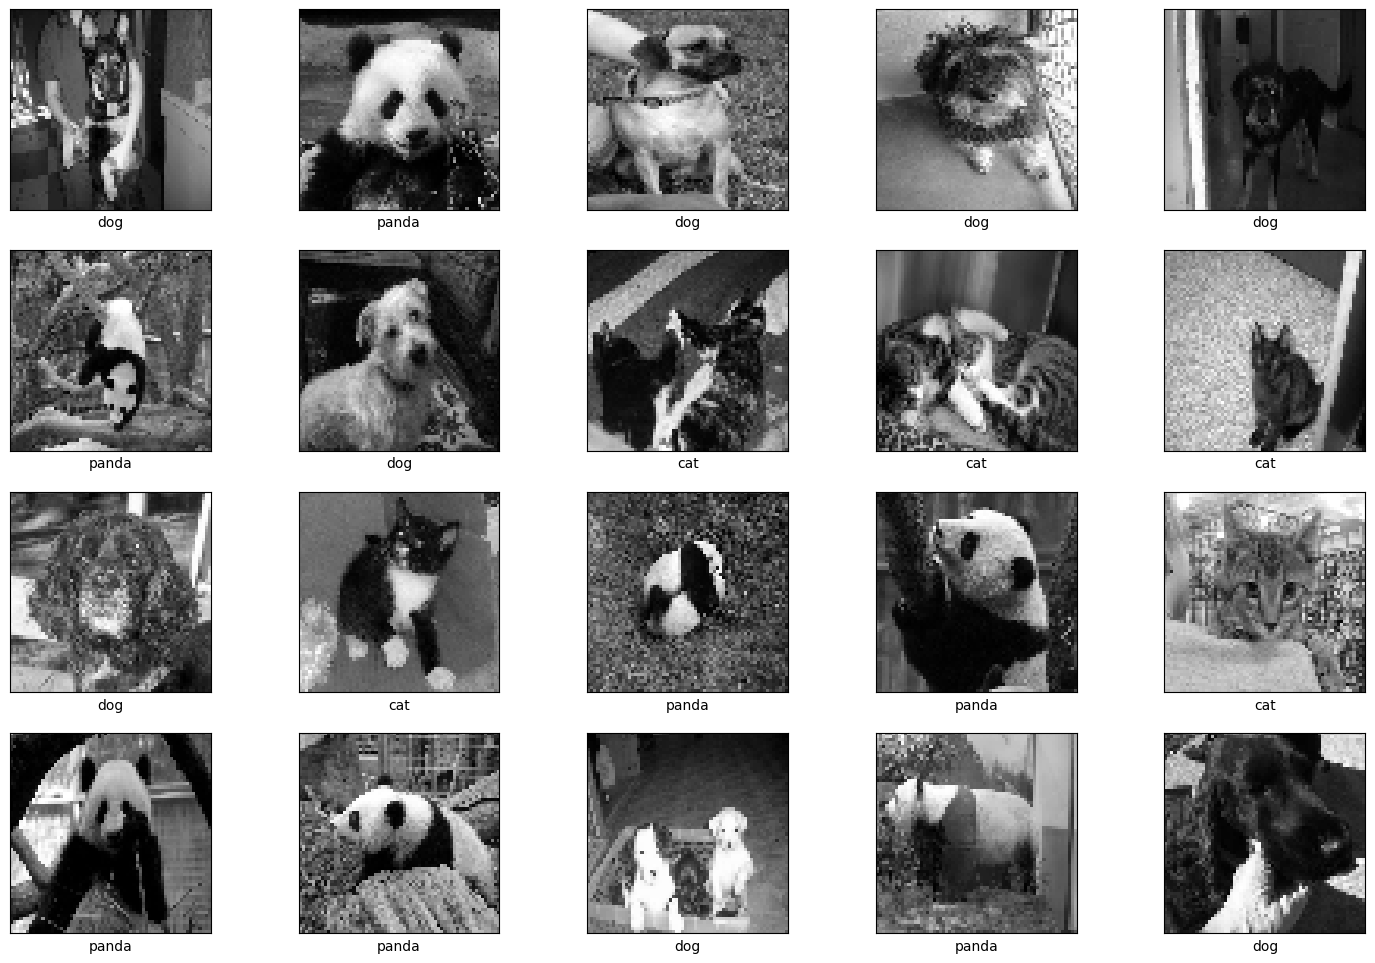

In [ ]:
#Display  Grayscale Images
random.shuffle(train_data)
plt.figure(figsize=(18,12))
for i in range(20):
    plt.subplot(4,5,i+1)
    image = train_data[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(Categories[train_data[i][1]])
    plt.xticks([]); plt.yticks([])
plt.show()


In [ ]:
#Distance Functions
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2)) #abs = absulate value

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [ ]:
f0 = train_data[0:60]
f1 = train_data[60:120]
f2 = train_data[120:180]
f3 = train_data[180:240]
f4 = train_data[240:300]


In [ ]:
#Calculate Nearest Neighbors
top_filter = 20
from tqdm import tqdm


def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold, desc="Calculating distances"):
        temp_dist_list = []
        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1], train[1], {"l1": l1_distance, "l2": l2_distance}])
        temp_dist_list.sort(key=lambda l: l[2]["l1"])
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=lambda l: l[2]["l2"])
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]


dist_by_fold = []
folds = [f0, f1, f2, f3, f4]
for i in range(5):
    valid = folds[i]
    train = sum([folds[j] for j in range(5) if j != i], [])
    dist_by_fold.append(distance_calc(train, valid))

Calculating distances: 100%|██████████| 60/60 [00:00<00:00, 96.52it/s]


In [ ]:
#Now I am calculating KNN accuracy
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class):
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

accuracies = []
for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

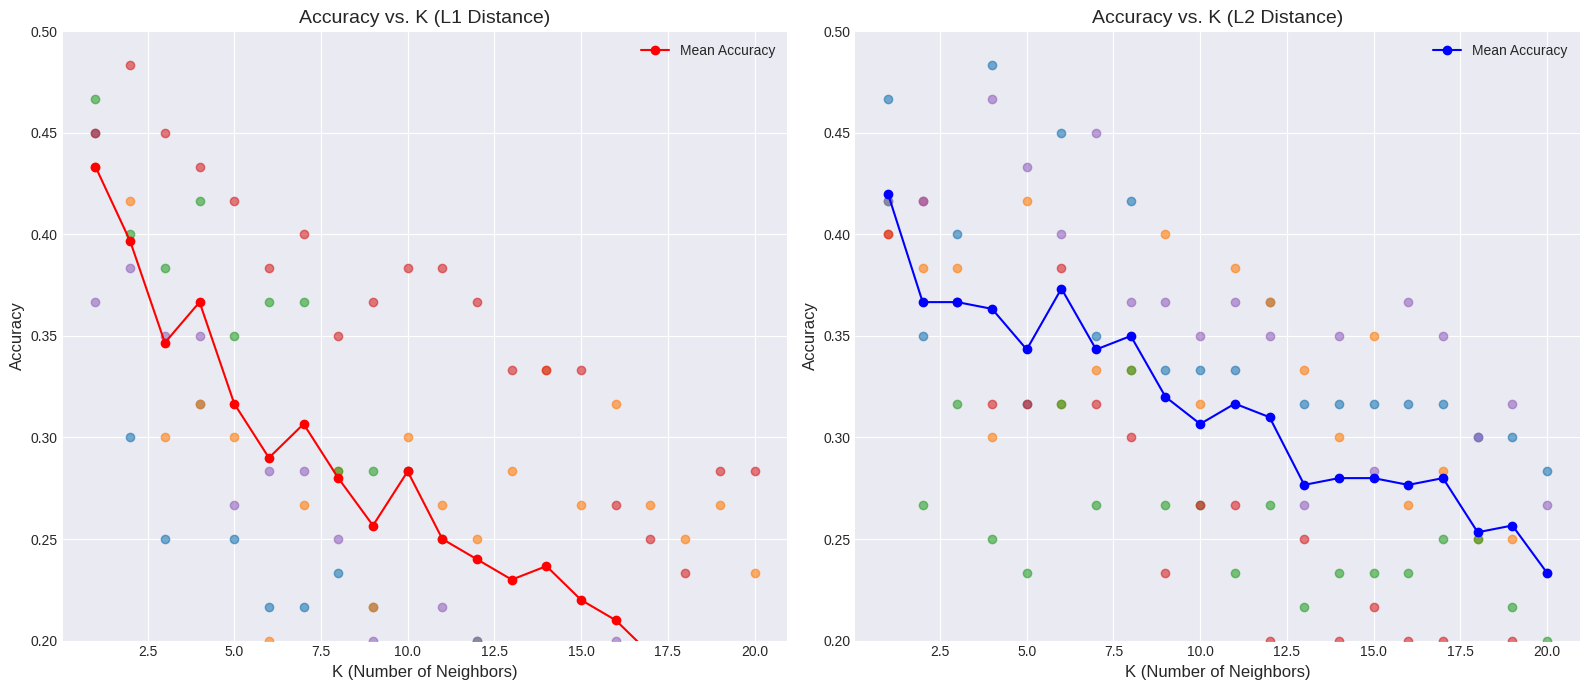

In [ ]:
#Accuracy vs. K
x_list = list(range(1, k_range+1))

plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Use subplots with a figure object

# L1 Distance Plot
ax1 = axes[0]
for fold in accuracies:
    y_list = fold[0]
    ax1.scatter(x_list, y_list, alpha=0.6, label='_nolegend_')
arr_l1 = [[fold[0][i] for fold in accuracies] for i in range(k_range)]
trend_l1 = [np.mean(a) for a in arr_l1]
ax1.plot(x_list, trend_l1, marker='o', linestyle='-', color='red', label='Mean Accuracy')
ax1.set_title('Accuracy vs. K (L1 Distance)', fontsize=14)
ax1.set_xlabel('K (Number of Neighbors)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0.2, 0.5)
ax1.legend()
# L2 Distance Plot
ax2 = axes[1]
for fold in accuracies:
    y_list = fold[1]
    ax2.scatter(x_list, y_list, alpha=0.6, label='_nolegend_') # Added alpha for better visibility
arr_l2 = [[fold[1][i] for fold in accuracies] for i in range(k_range)]
trend_l2 = [np.mean(a) for a in arr_l2]
ax2.plot(x_list, trend_l2, marker='o', linestyle='-', color='blue', label='Mean Accuracy')
ax2.set_title('Accuracy vs. K (L2 Distance)', fontsize=14)
ax2.set_xlabel('K (Number of Neighbors)', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylim(0.2, 0.5)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
random.shuffle(train_data)
test_images = []
for i in range(5):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images[:1]:
    distances1 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])
    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images[:1]:
    distances2 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])
    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")


Top 5 Predictions for L1 Distance:
Prediction 1: Class 'panda' with L1 distance 0.00
Prediction 2: Class 'cat' with L1 distance 4375.88
Prediction 3: Class 'dog' with L1 distance 4482.48
Prediction 4: Class 'panda' with L1 distance 4509.90
Prediction 5: Class 'dog' with L1 distance 4528.72

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'panda' with L2 distance 0.00
Prediction 2: Class 'cat' with L2 distance 642.49
Prediction 3: Class 'panda' with L2 distance 642.68
Prediction 4: Class 'panda' with L2 distance 644.66
Prediction 5: Class 'cat' with L2 distance 646.34


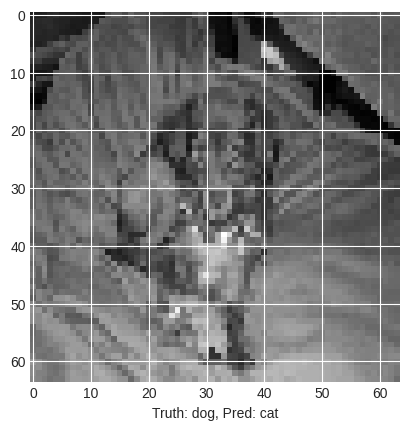

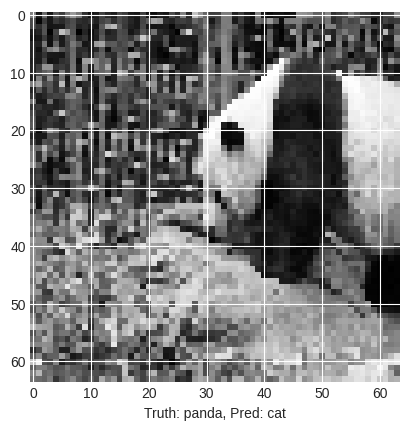

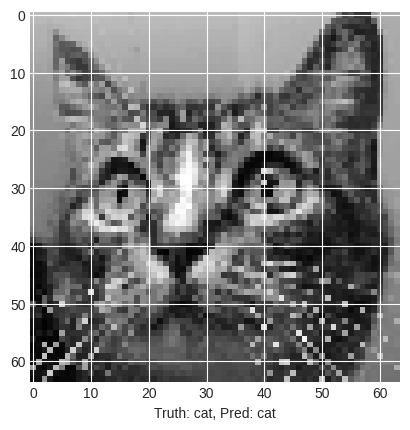

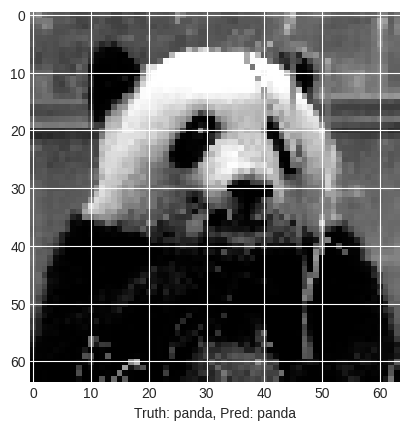

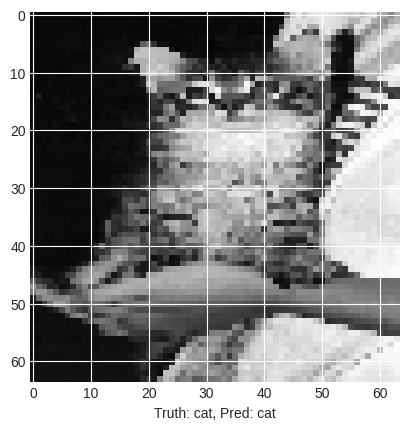

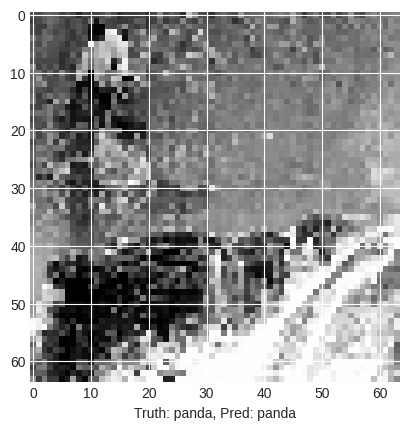

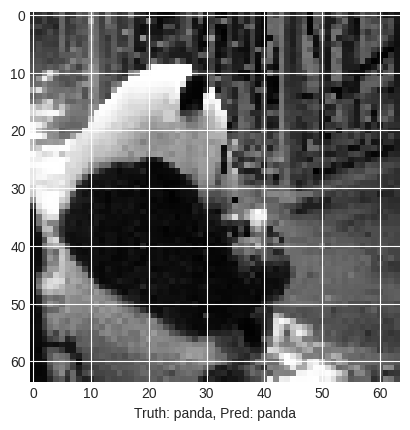

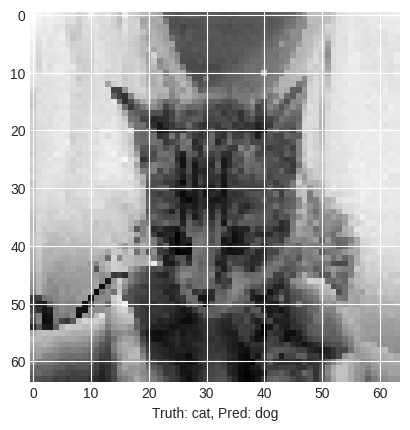

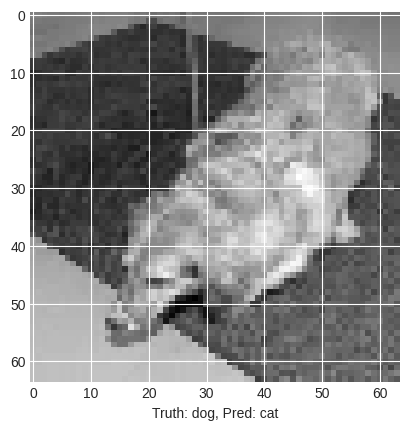

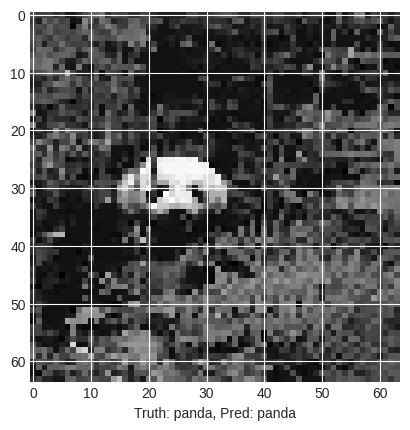

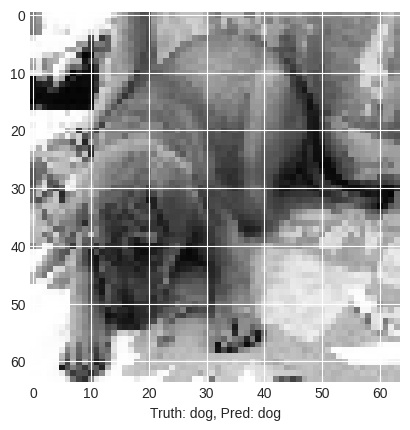

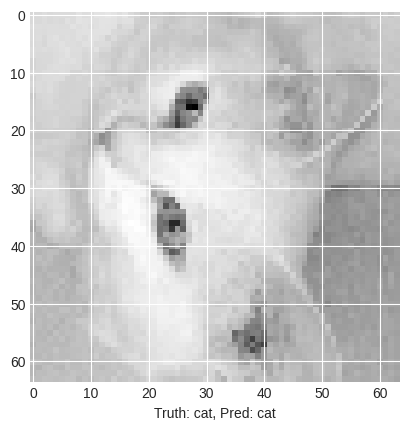

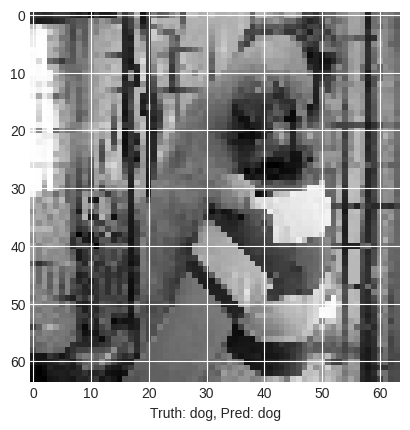

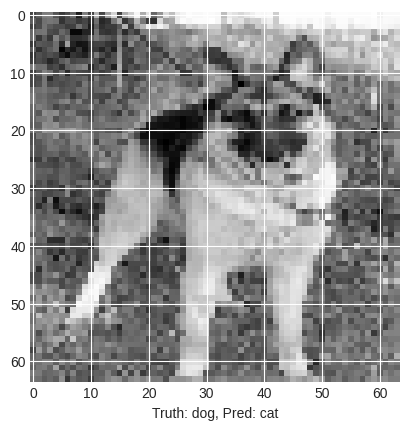

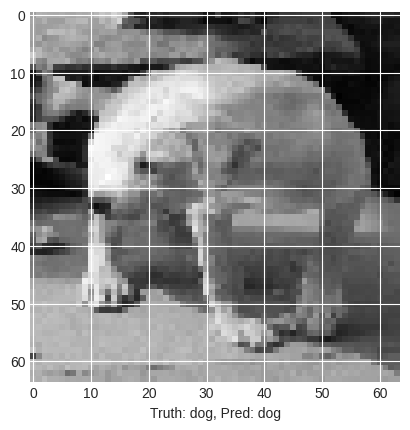

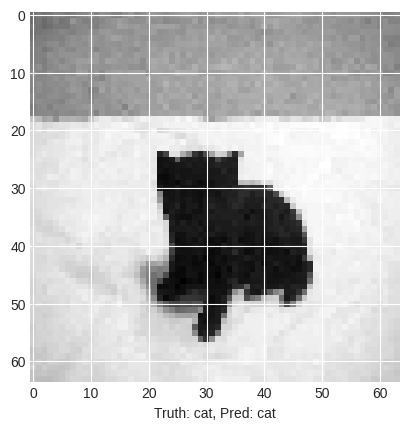

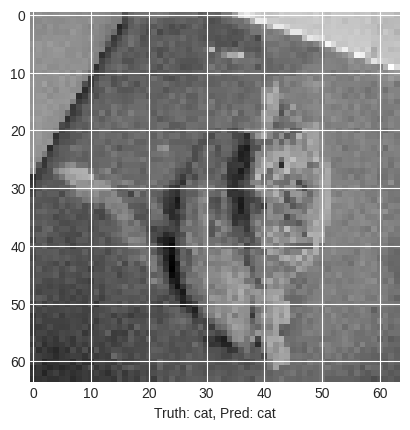

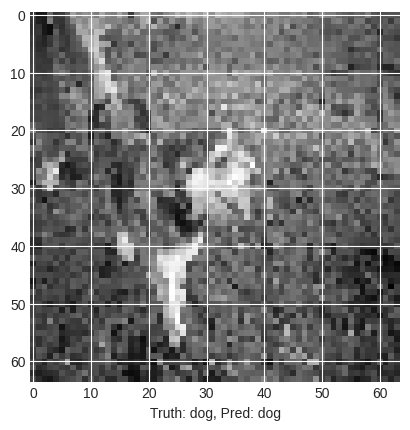

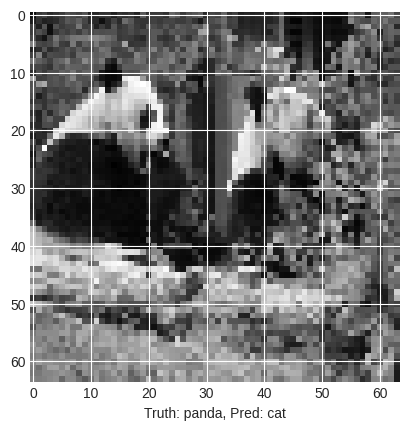

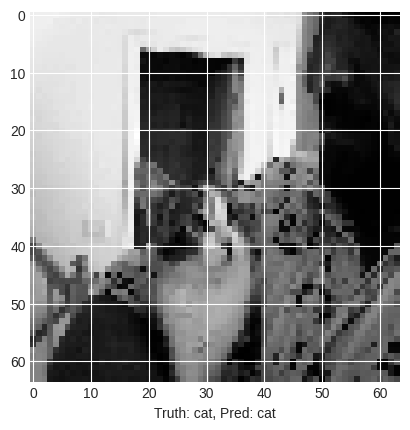

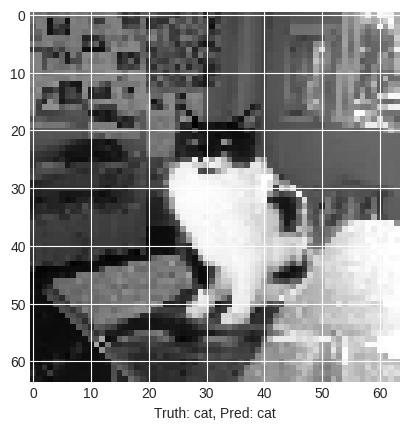

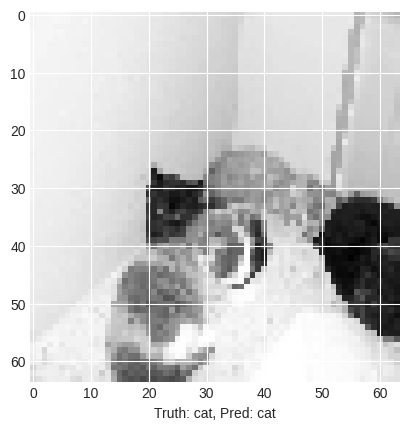

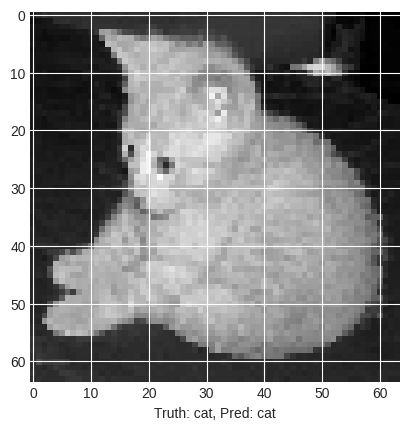

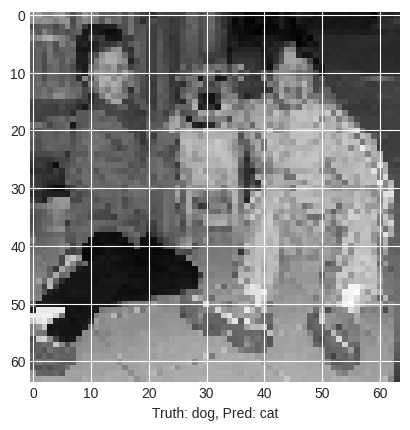

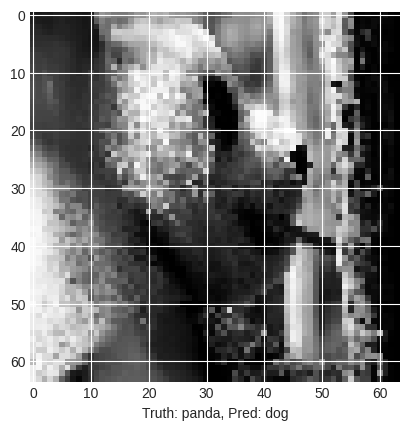

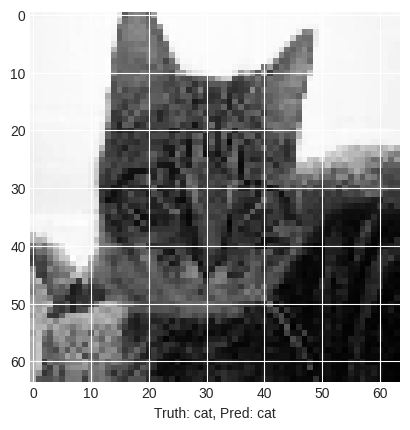

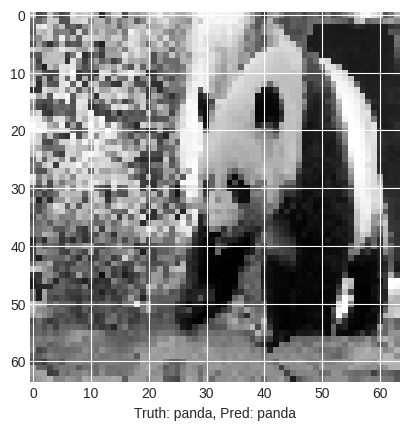

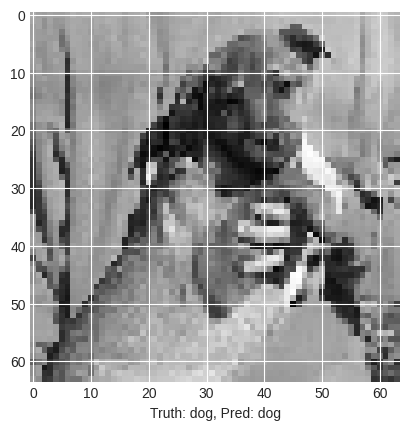

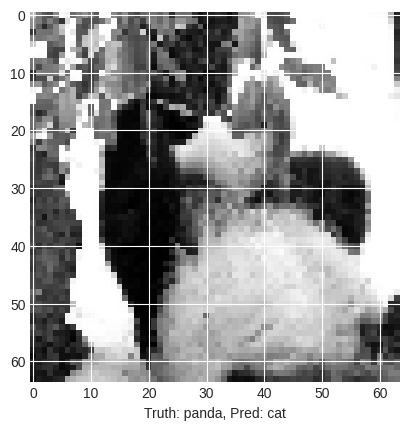

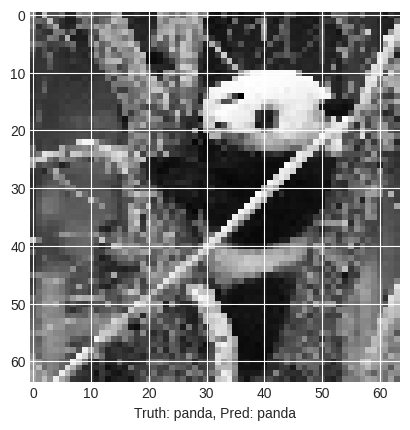

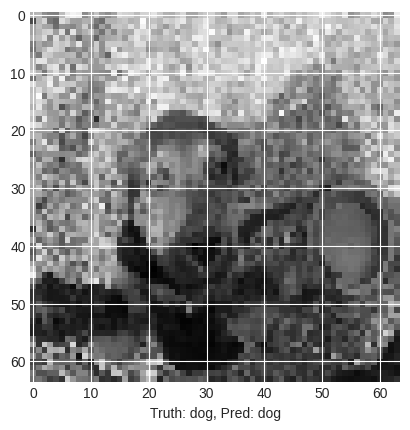

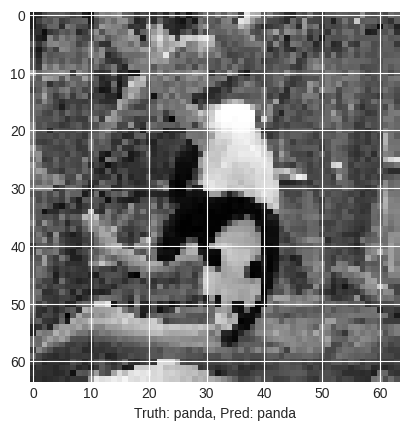

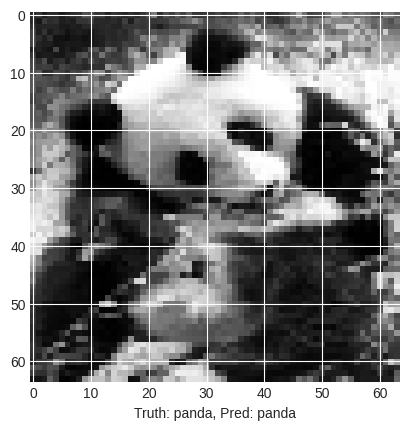

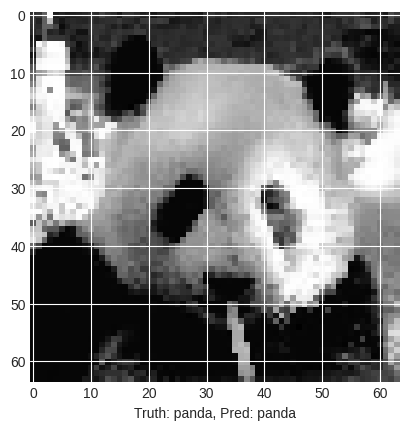

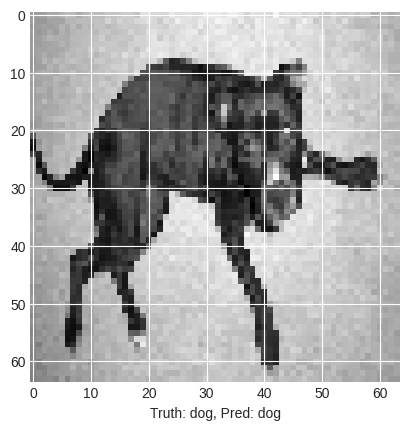

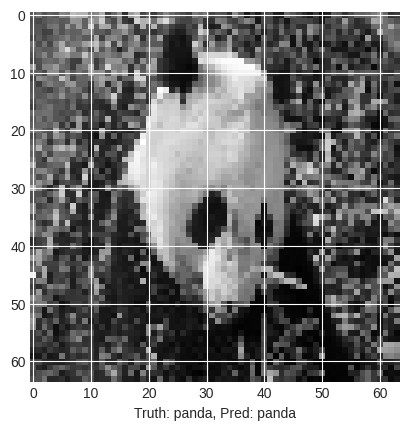

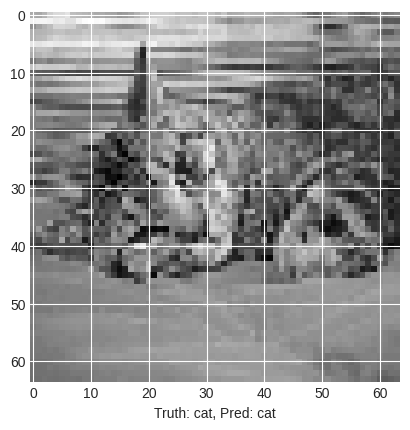

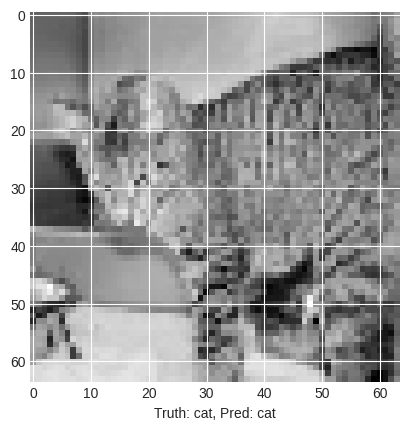

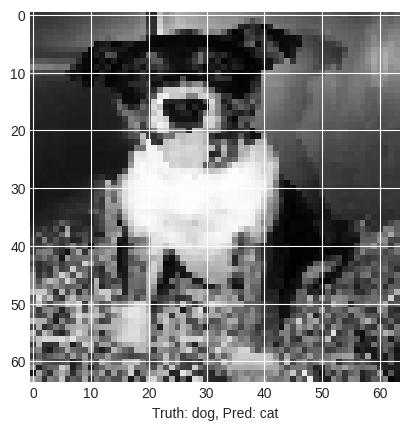

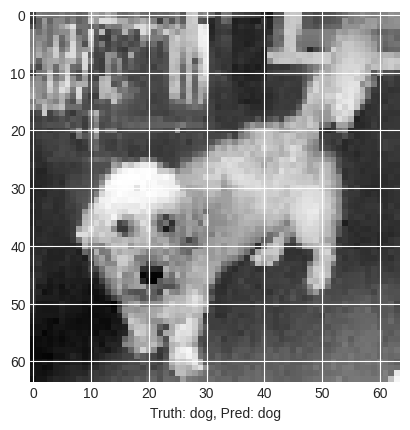

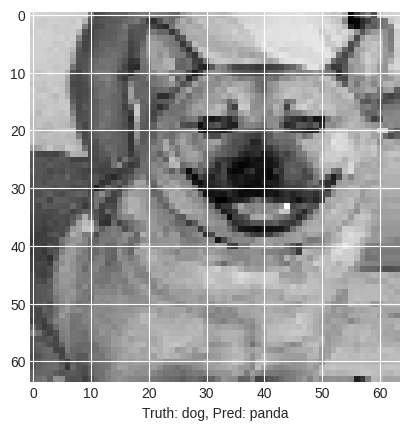

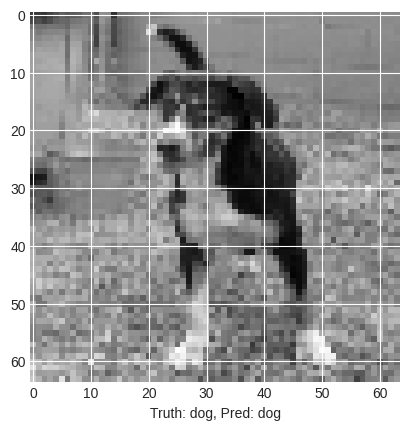

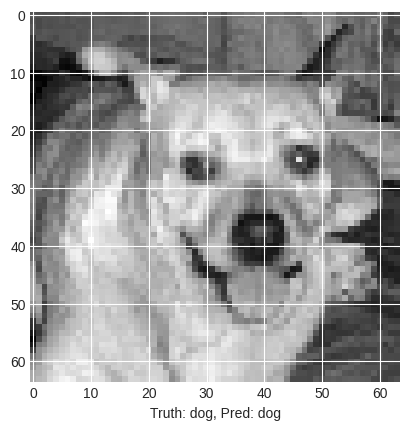

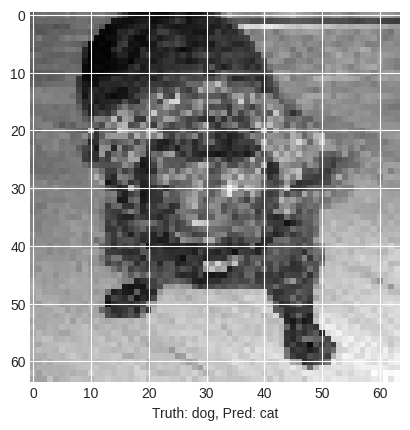

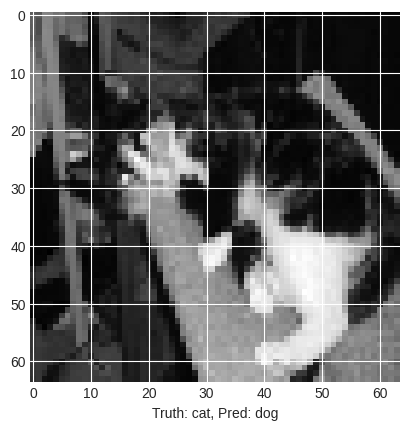

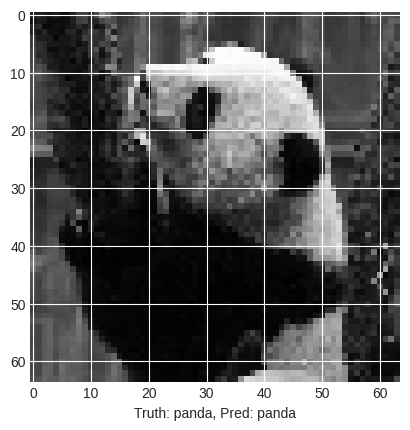

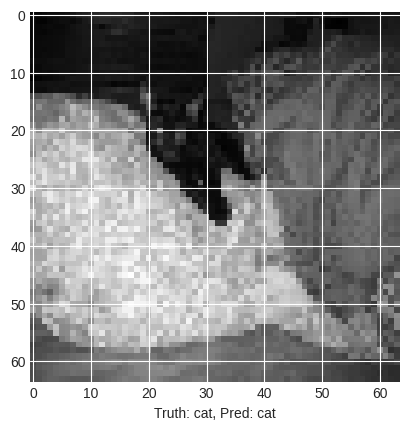

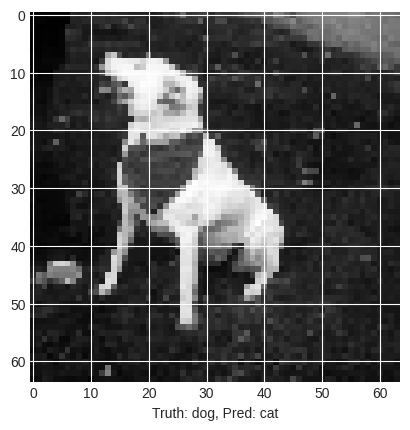

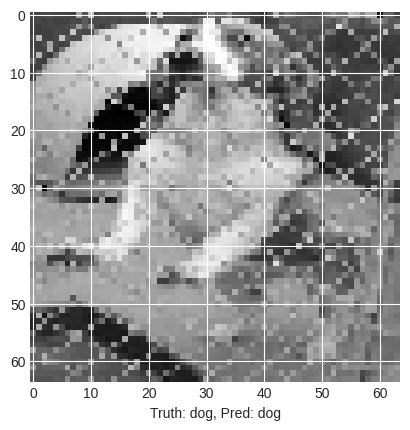

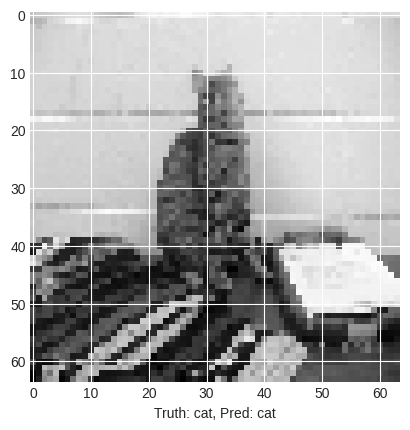

Correctly predicted 36 images out of 50, overall accuracy: 72.0 %


In [ ]:
random.shuffle(train_data)
test_images = []
neighbours = 3
test_count = 50

for i in range(test_count):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, train_data[i][1]])

accurate = 0

for test_image_gray in test_images:
    distances2 = []
    pred = None
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])
    prediction_classes = [[cl[0], Categories[cl[1]]] for cl in distances2[:neighbours]]
    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}
    for pc in prediction_classes:
        occurrences_dict[pc[1]][0] += 1
        occurrences_dict[pc[1]][1] += pc[0]
    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)
    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]
    if len(keys_with_max_value) == 1:
        pred = keys_with_max_value[0]
    else:
        elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
        min_count_1 = min(elements_at_index_1)
        keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
        pred = keys_with_min_value[0]
    truth = Categories[test_image_gray[1]]
    plt.figure()
    plt.imshow(test_image_gray[0], cmap="gray")
    plt.xlabel(f"Truth: {truth}, Pred: {pred}")
    plt.show()
    if truth == pred:
        accurate += 1

print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')


